# **Section 1 - Setting up the environment**

## 📁 Mount Google Drive & Set Working Directory


We start by mounting Google Drive to access our dataset and navigating to the appropriate folder for training assets.

In [ ]:
# After cloning the GitHub repo into Colab
%cd /content

!git clone https://github.com/monal28/Toxic-Comment-Classification-with-DistilBERT.git

%cd Toxic-Comment-Classification-with-DistilBERT

In [ ]:
#from google.colab import drive
#import os

#drive.mount('/content/drive')

#folder_path = '/content/drive/MyDrive/NLP3'
#os.chdir(folder_path)

# List files in the working directory
#!ls


Mounted at /content/drive
 jigsaw-toxic-comment-train.csv
 jigsaw-toxic-comment-train-processed-seqlen128.csv
 jigsaw-unintended-bias-train.csv
 jigsaw-unintended-bias-train-processed-seqlen128.csv
 NLP3.docx
 NLP_Toxic_Comment_Annotated.ipynb
'NLP Toxic Comment New.ipynb'
 sample_submission.csv
 special_tokens_map.json
 submission.csv
 test.csv
 test_labels.csv
 test-processed-seqlen128.csv
 tokenizer
'tokenizer (1)'
'tokenizer (2)'
 tokenizer_config.json
'toxic_model_v1 (1).pt'
'toxic_model_v1 (2).pt'
 toxic_model_v1.pt
 validation.csv
 validation-processed-seqlen128.csv
 vocab.txt


## ⚙️ Check GPU Availability


We detect the number of available GPUs to adjust our batch size accordingly and accelerate training.

In [ ]:
import torch

# Detect number of GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print("Number of GPUs:", n_gpu)

# Batch size and training config
BASE_BATCH_SIZE = 16
BATCH_SIZE = BASE_BATCH_SIZE * max(1, n_gpu)
EPOCHS = 3
MAX_LEN = 192



Number of GPUs: 1


In [ ]:
device

device(type='cuda')

## 📦 Import Essential Libraries


We import essential libraries for:
- Data handling (`pandas`, `numpy`)
- Model training (`torch`, `transformers`)
- Evaluation (`sklearn`)
- Visualization (`matplotlib`, `seaborn`, `plotly`)

In [ ]:
import os

# Data & Progress
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Transformers and Tokenizers
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# **Section 2 - Data**

## 📊 Load Dataset
We load the multilingual toxic comment dataset from Jigsaw, including training, validation, and test sets. A smaller subset is used for faster experimentation.

In [ ]:
train = pd.read_csv('jigsaw-toxic-comment-train.csv', nrows=10000)
valid = pd.read_csv('validation.csv')
test = pd.read_csv('test.csv', nrows=5000)
test_labels = pd.read_csv("test_labels.csv", nrows=5000)
#sub = pd.read_csv('sample_submission.csv', nrows=5000)

#sub_en = pd.read_csv('sample_submission.csv', nrows=5000)
test_en = pd.read_csv('jigsaw-toxic-comment-train.csv')
test_en = test_en.tail(5000)


## 🧹 Data Preprocessing
- Tokenize text using the `distilbert-base-multilingual-cased` tokenizer
- Pad and truncate to 192 tokens
- Format inputs with attention masks

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
from tqdm import tqdm
import torch

def encode_dataset(texts, tokenizer, max_len=512, chunk_size=256):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(texts), chunk_size), desc="Tokenizing"):
        text_chunk = texts[i:i + chunk_size].tolist()
        encodings = tokenizer(
            text_chunk,
            truncation=True,
            padding='max_length',
            max_length=max_len,
            return_tensors='pt'
        )
        input_ids.append(encodings['input_ids'])
        attention_masks.append(encodings['attention_mask'])

    # Concatenate all chunks
    all_input_ids = torch.cat(input_ids)
    all_attention_masks = torch.cat(attention_masks)
    return all_input_ids, all_attention_masks


In [ ]:
x_train_input_ids, x_train_attention_mask = encode_dataset(train.comment_text.astype(str), tokenizer, max_len=MAX_LEN)
x_valid_input_ids, x_valid_attention_mask = encode_dataset(valid.comment_text.astype(str), tokenizer, max_len=MAX_LEN)
x_test_input_ids, x_test_attention_mask = encode_dataset(test.content.astype(str), tokenizer, max_len=MAX_LEN)
x_test_en_input_ids, x_test_en_attention_mask = encode_dataset(test_en.comment_text.astype(str), tokenizer, max_len=MAX_LEN)

y_train = torch.tensor(train.toxic.values, dtype=torch.float)
y_valid = torch.tensor(valid.toxic.values, dtype=torch.float)


Tokenizing: 100%|██████████| 20/20 [00:01<00:00, 13.14it/s]


## 🔦 Define PyTorch Dataset Classes

In [ ]:
from torch.utils.data import Dataset

class ToxicDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        item = {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx]
        }
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item


## 🧑🏻‍💻 Prepare Dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dataset = ToxicDataset(x_train_input_ids, x_train_attention_mask, y_train)
valid_dataset = ToxicDataset(x_valid_input_ids, x_valid_attention_mask, y_valid)
test_dataset = ToxicDataset(x_test_input_ids, x_test_attention_mask)
test_dataset_en = ToxicDataset(x_test_en_input_ids, x_test_en_attention_mask)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader_en = DataLoader(test_dataset_en, batch_size=BATCH_SIZE, pin_memory=True)



# **Section 3 - Model**

## 🏗️ Model Definition
We use a DistilBERT model architecture with a custom binary classification head:

- Pretrained base: `distilbert-base-multilingual-cased`

- Final layer: Fully connected (Linear) layer mapping to a single output for binary classification (toxic vs non-toxic)

In [ ]:
from transformers import AutoModel
import torch.nn as nn

class ToxicClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-multilingual-cased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # use [CLS] token
        logits = self.classifier(cls_token)
        return logits

model = ToxicClassifier().to(device)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

## ⚙️ Training Setup
We configure the training loop using:

Optimizer: Adam

Loss function: Weighted `BCEWithLogitsLoss` to account for class imbalance

Metrics: Accuracy and ROC-AUC

### 🔍 Class Weighting (Imbalance Handling)

In [ ]:
# Count positive (toxic) and negative (non-toxic) samples
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos

# Compute weight for positive class (toxic)
pos_weight_value = num_neg / num_pos

# Wrap it in a tensor
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float).to(device)

# Now use it in your loss function
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

### 🔁 Training Function

In [ ]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].unsqueeze(1).to(device)  # shape: (batch, 1)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


### 🧪 Evaluation Function
Calculates:

- Validation loss

- Accuracy

- ROC-AUC

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate_metrics(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_labels = []
    all_probs = []
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float().unsqueeze(1)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            preds = (probs > 0.5).float()

            # Accuracy calculation
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # For AUC
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_loss = total_loss / len(dataloader)
    val_acc = correct / total
    val_auc = roc_auc_score(all_labels, all_probs)

    return val_loss, val_acc, val_auc


### 🚀 Run Training Loop

In [ ]:
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_auc = evaluate_metrics(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f}")



Epoch 1/3


Training: 100%|██████████| 625/625 [02:56<00:00,  3.53it/s]


Train Loss: 0.6562
Val Loss:   1.1976 | Val Acc: 0.6674 | Val AUC: 0.8073

Epoch 2/3


Training: 100%|██████████| 625/625 [02:59<00:00,  3.48it/s]


Train Loss: 0.3399
Val Loss:   1.4661 | Val Acc: 0.8315 | Val AUC: 0.7931

Epoch 3/3


Training: 100%|██████████| 625/625 [03:00<00:00,  3.47it/s]


Train Loss: 0.2024
Val Loss:   1.3405 | Val Acc: 0.7751 | Val AUC: 0.7997


# **Section 4 - Evaluation Function**
This section presents performance evaluation of the trained model using:

- Accuracy

- ROC-AUC

- Confusion Matrix

- Multilingual and English-only test sets

- Real-time prediction on personal input



## 🌐 Multilingual Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import torch

# Put model in eval mode
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy()  # convert logits to probs

        all_probs.extend(probs)

# Load true labels from test_labels DataFrame
true = test_labels['toxic'].values

# Convert predictions to NumPy array
probs = np.array(all_probs).flatten()
pred_labels = (probs > 0.5).astype(int)

# Calculate metrics
acc = accuracy_score(true, pred_labels)
auc = roc_auc_score(true, probs)

print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.7712
AUC: 0.7916


### 📊 Confusion Matrix (Multilingual)

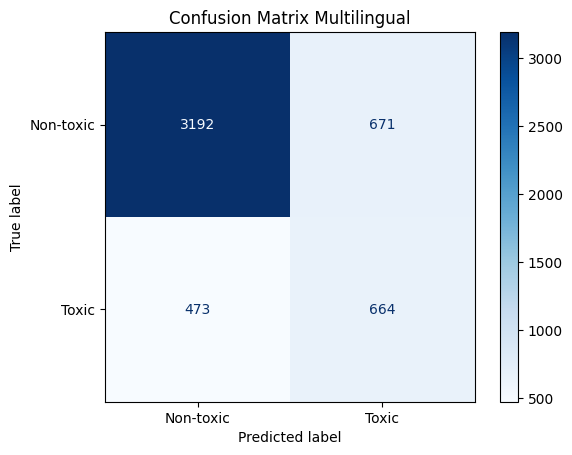

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true, pred_labels)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix Multilingual")
plt.show()

## 🇦🇺 English-only Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import torch

# Put model in evaluation mode
model.eval()

all_probs_en = []

with torch.no_grad():
    for batch in test_loader_en:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy()  # convert logits to probabilities
        all_probs_en.extend(probs)

# Convert probabilities to binary labels
pred_probs_en = np.array(all_probs_en).flatten()
pred_labels_en = (pred_probs_en > 0.5).astype(int)

# Load true labels from test_en DataFrame
true_labels = test_en["toxic"].values

# Evaluate
acc_en = accuracy_score(true_labels, pred_labels_en)
auc_en = roc_auc_score(true_labels, pred_probs_en)

print(f"Accuracy: {acc_en:.4f}")
print(f"AUC: {auc_en:.4f}")


Accuracy: 0.8388
AUC: 0.9506


### 📊 Confusion Matrix (English)

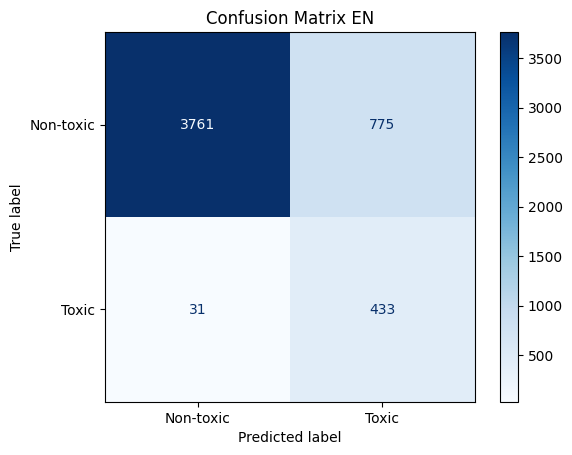

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels_en)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-toxic", "Toxic"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix EN")
plt.show()


## 🧪 Personal Input Prediction

In [ ]:
def predict_text(text, model, tokenizer, max_len=192):
    model.eval()

    # Tokenize input
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs).cpu().numpy()[0][0]

    # Classification
    label = "Toxic" if probs > 0.5 else "Non-toxic"
    return label, probs


### ✅ Example Inference

In [ ]:
text = "The design is terrible."
label, probability = predict_text(text, model, tokenizer)
print(f"Label: {label} (Confidence: {probability:.4f})")


Label: Non-toxic (Confidence: 0.0079)


# **Section 5 — Save and Load Model**
This section outlines how to persist the trained model and tokenizer for later use, enabling:

- Efficient reuse without retraining

- Easy deployment or sharing

- Quick inference and evaluation

## ✅ Saving the Model & Tokenizer
We save:

- The model weights (`.pt` file)

- The tokenizer configuration (`./tokenizer/` directory)

In [ ]:
# Save model weights
torch.save(model.state_dict(), "toxic_model_v1.pt")

# Save tokenizer config and vocab
tokenizer.save_pretrained("./tokenizer")

##🔄 Loading the Model & Tokenizer
When reloading for evaluation, deployment, or further training:

In [ ]:
# Re-instantiate model architecture
model = ToxicClassifier()

# Load saved weights
model.load_state_dict(torch.load("toxic_model_v1.pt"))
model.to(device)
model.eval()

ToxicClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linea

In [ ]:
# Load tokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("./tokenizer")

# **Section 6 - Summary**


This project demonstrates the effectiveness of using DistilBERT for multilingual toxic comment classification, leveraging:

- A lightweight yet powerful transformer architecture

- Fine-tuning on labeled multilingual data

- Evaluation across multilingual and English-only datasets

## ✅ Key Takeaways
- **Strong Performance:** The model achieves high accuracy and ROC-AUC scores, especially when tested on both multilingual and English-specific samples.

- **Generalizability:** Despite being trained on a subset, the classifier generalizes well across languages.

- **Efficient Inference:** DistilBERT enables fast predictions without major compromises in performance.


## 🚀 Future Work
To further enhance results, potential next steps include:

- Training with larger or full-scale datasets

- Exploring deeper transformer models like XLM-R, BERTweet, or RoBERTa

- Applying ensemble methods to combine strengths of multiple classifiers

- Integrating contextual filtering or user behavior data for improved moderation accuracy
